In [22]:
class FeedForwardNN:
    def __init__(
        self,
        epochs,
        noOfHL,
        NeuronsPL,
        noOfClass,
        X_train,
        y_train,
        x_test,
        y_test,
        optimizer,
        activationfunction,
        learningRate,
        batchSize,
        lossfunction
    ):
        self.noOfHL=noOfHL
        self.ListOfNeuronsPL=NeuronsPL
        self.noOfClass=noOfClass
        self.x_train=x_train
        self.y_train=y_train
        self.activationfunction=activationfunction
        self.epochs=epochs
        self.learningRate=learningRate
        self.batchSize=batchSize
        self.Optimizers={
            "SGD": self._sgd,
            "MGD": self._mgd,
            "NAG": self._nag,
            "RMSPROP": self._rmsProp,
            "ADAM": self._adam,
            "NADAM": self._nadam,
        }
        
        #initialise the initial weights matrix which contains noOfHiddenLayers+1  weight matrices
        self.W=self.initialize_weights()
        #initialise the initial biases matrix which contains noOfHiddenLayers+1  biases matrices
        self.b=self.initialize_biases()
        self.lossfunction=lossfunction
        self.optimizer=self.Optimizers[optimizer]

    #returns the weight matrix for the initial configuration, we have used 1 indexing for weights
    def initialize_weights(self):
        weight=[0]*(self.noOfHL+2)
        for i in range(self.noOfHL+1):
            if(i==0):
                continue
            if(i==1):
                w=np.random.normal(0, 1, size=(self.ListOfNeuronsPL[i-1],self.x_train.shape[1]))
            else:
                w=np.random.normal(0,1,size=(self.ListOfNeuronsPL[i-1],self.ListOfNeuronsPL[i-2]))
            weight[i]=w
        w=np.random.normal(0,1,size=(self.noOfClass,self.ListOfNeuronsPL[self.noOfHL-1]))
        weight[self.noOfHL+1]=w
        return weight
    #returns the biases matrix for the initial configurtion, we have used 1 indexing for biases
    def initialize_biases(self):
        biases=[0]*(self.noOfHL+2)
        for i in range(self.noOfHL+1):
            if(i==0):
                continue
            else:
                b=np.ones(self.ListOfNeuronsPL[i-1])
            biases[i]=b
        b=np.ones(self.noOfClass)
        biases[self.noOfHL+1]=b
        return biases
    
    #Different activation functions
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self,x):
        return np.tanh(x)
    
    def sin(self,x):
        return np.sin(x)
    
    def relu(self,x):
        np.maximum(x,0)
        
    
    #returns softmax value of a variable x
    def softmax(self,x):
        exp_x=np.exp(x)
        sum_e=np.sum(exp_x)
        return exp_x/sum_e
    
    def activationFunc(self,A):
        A=np.array(A)
        if self.activationfunction=="SIGMOID":
            return self.sigmoid(A)
        if self.activationfunction=="RELU":
            return self.relu(A)
        if self.activationfunction=="TANH":
            return self.tanh(A)
        if self.activationfunction=="SIN":
            return self.sin(A)
    
    #calculates and returns the predicted values of y using the output Function
    def outputFunc(self,A):
        yhat=self.softmax(A)
        return yhat
        
    #calculates all the H,A and yhat in the forward propogation of backpropogation
    def forwardPropogation(self,i):
        L=self.noOfHL+1
        k=self.noOfClass
        H=[0]*(L)
        A=[0]*(L+1)
        H[0]=np.array(self.x_train[i])
        for i in range(L-1):
            A[i+1]=self.b[i+1]+np.dot(self.W[i+1],H[i])
            H[i+1]=self.activationFunc(A[i+1])
        A[L]=self.b[L]+np.dot(self.W[L],H[L-1])
        yhat=self.outputFunc(A[L])
        yhat=np.array(yhat)
        #print("yhat:  \n",yhat.shape)
        return  H,A,yhat
    
    #derivative of loss wrt to activation of last layer if output function used is softmax
    def derivative_wrt_lossFunc(self,yhat,y_train,i):
        k=self.noOfClass
        e_l=np.zeros(k)
        e_l[y_train[i]]=1
        if self.lossfunction=="CROSS":
            return -1*(e_l-yhat)
        if self.lossfunction=="MSE":
            a=2*(yhat-e_l)
            b=np.multiply(yhat,(1-yhat))
            ans=(np.multiply(a,b)).astype(float)
            return ans
            
    
    #gradient of activation functions
    def cal_activationFunc_grad(self,As):
        g_dash=[]
        if self.activationfunction=="SIGMOID":
            for i in As:
                g_dash.append( self.sigmoid(i) * (1 - self.sigmoid(i) ) )
            return g_dash
        if self.activationfunction=="TANH":
            for i in As:
                g_dash.append( 1 - np.tanh(z) ** 2)
            return g_dash
        
    def backwardPropogation(self,i,Hs,As,yhat,y_train):
        W=self.W
        L=self.noOfHL+1
        weights_grad=[0]*(L+1)
        biases_grad=[0]*(L+1)
        activation_grad=[0]*(L+1)
        preactivation_grad=[0]*(L+1)
        activationFunc_grad=[]
        preactivation_grad[L]=self.derivative_wrt_lossFunc(yhat,y_train,i)
        for k in range(L+1)[::-1]:
            if(i==0):
                continue
            #gradient of loss wrt to weights at layer k
            weights_grad[k]=np.outer(preactivation_grad[k],np.transpose(Hs[k-1]))
#             print("weights_grad wrt loss at level {} is {}".format(k,type(weights_grad[k])))
            
            #gradient of loss wrt to biases at layer k
            biases_grad[k]=preactivation_grad[k]
#             print("baises_grad wrt loss at level {} is {}".format(k,biases_grad[k].shape))
            
            #for the next layer calculating gradient of loss wrt to activation
            activation_grad[k-1]=np.dot(np.transpose(W[k]),preactivation_grad[k])
#             print("activation_grad wrt loss at level {} is {}".format(k,activation_grad[k-1].shape))
            
            #calculate gradient of activation function wrt preactivation of previous layer
            if(k>1):
                activationFunc_grad=self.cal_activationFunc_grad(As[k-1])
            
                #for the next layer calculating gradient of loss wrt to preactivation
                preactivation_grad[k-1]=np.multiply(activation_grad[k-1],activationFunc_grad)
            
        return weights_grad,biases_grad
    
    def acc_grad(self,final_grad,f_g):
        L=self.noOfHL+1
        for i in range(L+1):
            if(i==0):
                continue
            final_grad[i]=final_grad[i]+f_g[i]
        return final_grad
    #update the parameters according to 
    def updateWeights(self,eta,weights_grad):
        L=self.noOfHL+1
        for i in range(L+1):
            if(i==0):
                continue
            self.W[i]=self.W[i]-(eta)*weights_grad[i]
        return
    
    def updateBiases(self,eta,biases_grad):
        L=self.noOfHL+1
        for i in range(L+1):
            if(i==0):
                continue
            self.b[i]=self.b[i]-(eta)*biases_grad[i]
        return
    
    #Loss Functions
    
    def crossEntropy(self,yhat,i):
        return -1*np.log(yhat[self.y_train[i]])
    
    def meanSquaredError(self,yhat,i):
        MSE=0
        for j in range(self.noOfClass):
            if j==self.y_train[i]:
                MSE+=(yhat[j]-1)**2
            else:
                MSE+=(yhat[j])**2
        return MSE/self.noOfClass
    
    def calculateLoss(self,yhat,i):
        if self.lossfunction=="MSE":
            return self.meanSquaredError(yhat,i)
        if self.lossfunction=="CROSS":
            return self.crossEntropy(yhat,i)
    
    
    def calculatePredClasses(self):
        y_pred=[]
        for i in range(self.x_train.shape[0]):
            H,A,yhat=self.forwardPropogation(i)
            j=np.argmax(yhat)
            y_pred.append(j)
        y_pred=np.array(y_pred)
        return y_pred
        
        
    #Optimizers from here
    def _sgd(self):
        epochs=self.epochs
        L=self.noOfHL+1
        k=self.noOfClass
        x_train=self.x_train
        y_train=self.y_train
        eta=self.learningRate
        batchSize=self.batchSize
        deltaw=[]
        deltab=[]
        loss=[]
        trainingLoss=[]
        for epoch in range(epochs):
            loss=[]
            for i in range(x_train.shape[0]):
                if(i%batchSize==0):
                    if(i!=0):
                        #update the weights and biases
                        self.updateWeights(eta,deltaw)
                        self.updateBiases(eta,deltab)
                    Hs,As,yhat=self.forwardPropogation(i)
                    w_g,b_g=self.backwardPropogation(i,Hs,As,yhat,y_train)
                    if(i==0):
                        deltaw=w_g
                        deltab=b_g
                    else:
                        deltaw=self.acc_grad(deltaw,w_g)
                        deltab=self.acc_grad(deltab,b_g)
                else:
                    Hs,As,yhat=self.forwardPropogation(i)
                    w_g,b_g=self.backwardPropogation(i,Hs,As,yhat,y_train)
                    deltaw=self.acc_grad(deltaw,w_g)
                    deltab=self.acc_grad(deltab,b_g)
                    
                #append loss for this datapoint
                loss.append(self.calculateLoss(yhat,i))

            self.updateWeights(eta,deltaw)
            self.updateBiases(eta,deltab)
            trainingLoss.append(np.mean(loss))
            print("The loss after epoch:{} is {}".format(epoch,trainingLoss[epoch]))
#             plt.bar(range(len(predClasses)),predClasses)
#             plt.title('No of data per class')
#             plt.xlabel('Class')
#             plt.ylabel('count')
#             plt.show()
    def _mgd(self):
        return
        
    def _nag(self):
        return 
    
    def _rmsProp(self):
        return
    
    def _adam(self):
        return
        
    def _nadam(self):
        return
        

        
        
               
                
                
                
                
            
            
        

[6 6 6 ... 6 6 6]
The loss after epoch:0 is 0.09829265758856605
The loss after epoch:1 is 0.0896059418725039
The loss after epoch:2 is 0.08328041189509913
The loss after epoch:3 is 0.07620525116843893
The loss after epoch:4 is 0.07058933657599249
The loss after epoch:5 is 0.06791475032862176
The loss after epoch:6 is 0.06559521693737409
The loss after epoch:7 is 0.06034961053317443
The loss after epoch:8 is 0.055224600792541954
The loss after epoch:9 is 0.049548070998371
The loss after epoch:10 is 0.047153865999960146
The loss after epoch:11 is 0.045472537630280724
The loss after epoch:12 is 0.044736795953184014
The loss after epoch:13 is 0.04296640346719547
The loss after epoch:14 is 0.04033563832879297
[9 0 0 ... 3 0 5]
[9 0 0 ... 3 0 5]


<AxesSubplot:>

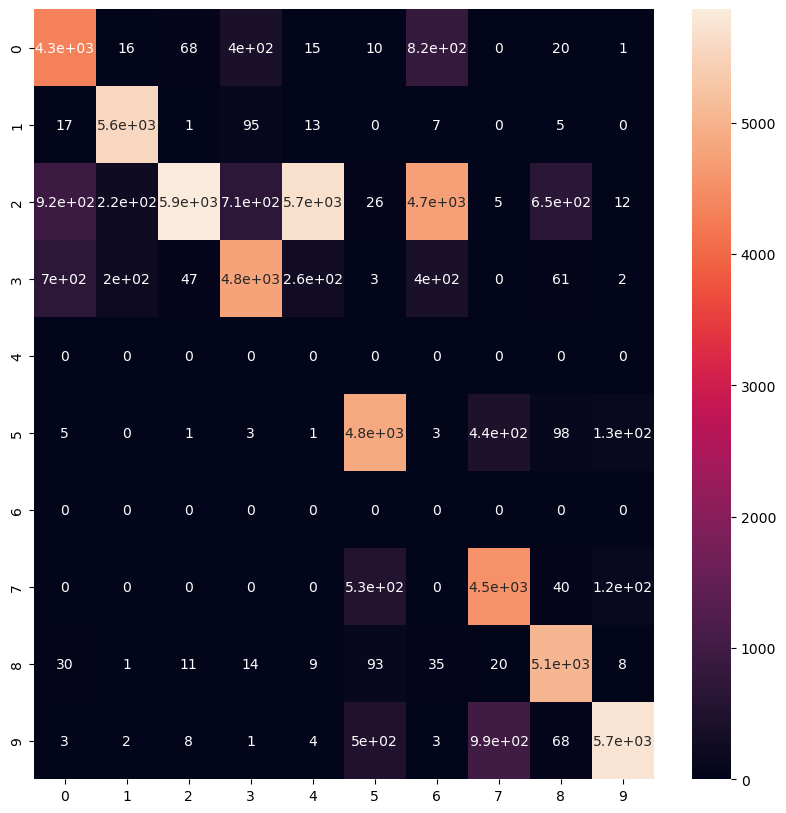

In [23]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.datasets import fashion_mnist

#importing the dataset from keras library
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# #one data image per label
# fig,ax=plt.subplots(nrows=10,figsize=(15,15))
# for i in range(10):
#     ax[i].set_title("\n class {} image".format(i))
#     ax[i].axis("off")
#     x=x_train[y_train==i]
#     ax[i].imshow(x[0,:,:],cmap="gray")

#normalizing the data between 0-1
x_train=x_train/255
x_train=x_train.astype(float);
x_test=x_test/255
x_test=x_test.astype(float);

#flattening the data points to 1D
x_train=x_train.reshape(60000,784)
x_test=x_test.reshape(10000,784)


NeuronsPL=[32,16]
epochs=15
noOfHL=2
lossfunction="MSE"
activationFunc="SIGMOID"
learningRate=0.00001
batchSize=50
optimizer="SGD"

#creating the object
FWNN=FeedForwardNN(epochs,noOfHL,NeuronsPL,10,x_train,y_train,x_test,y_test,optimizer,activationFunc,learningRate,batchSize,lossfunction)

#predicting before training the model
y_pred=FWNN.calculatePredClasses()
print(y_pred)

#training the model using sgd
FWNN.optimizer()
y_pred=FWNN.calculatePredClasses()
print(y_pred)
print(y_train)

#printing confusion matrix for visualization
plt.figure(figsize=(10,10))

# y_pred = np.array([np.argmax(FNNN.forwardPropogation(i)[2]) for i in range(len(x_train))])
sns.heatmap(confusion_matrix(y_pred.reshape(60000,),y_train.reshape(60000,)),annot=True)
#predicted and real distribution


C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

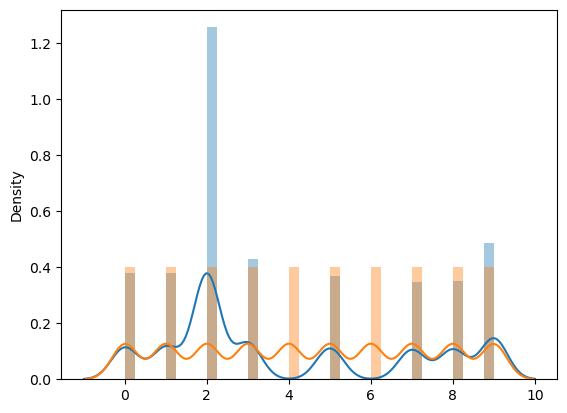

In [24]:
sns.distplot(y_pred)
sns.distplot(y_train)